*** 
# CAO Points Analysis <br>
***

<br><br>

## Acquiring the Data
### 2021 [Data link:](http://www.cao.ie/index.php?page=points&p=2021)
***

In [1]:
# import required libraries
import pandas as pd               # for manipulating data / making dataframes
import numpy as np                # for numerical operations
import matplotlib.pyplot as plt   # for plotting
import seaborn as sns             # for plotting

import requests as rq             # Convenient HTTP requests
import re                         # Regular expressions

import urllib3                    # to make HTTP requests (pool manager object)
import io                         # for storing binary data (io.BytesIO())
import pdfplumber                 # for scraping the pdf

# for plot formatting
plt.rcParams['font.size'] = 13             
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [2]:
# Make a get request to 2021 CAO points URL
resp = rq.get('http://www2.cao.ie/points/l8.php')

# Check that value = 200 (in which case a connection is made).
resp

<Response [200]>

<br>

**Encoding note:<br>Error on server** <br>
The Server indicated one should decode as per: Content-Type: text/html; charset=iso-8859-1. However, one line of the html uses<br> 
\x96 which isn't defined in iso-8859-1. Therefore the similar decoding standard cp1252 will be  used. This standard is very similar but<br>
includes \x96.

In [3]:
# Specify encoding method 
resp.encoding = 'cp1252'

# Create a file path for the original data.
html_path = 'data/2021/cao_2021_raw_data.html'

# Save original html file
with open(html_path, 'w') as f:
    f.write(resp.text)

In [4]:

def scrape_html_from_website(path, regex):
    '''Srapes website (pre-defined request) using passed regex and writes result to passed folder path'''
    
    num_lines = 0                                       # Keep track of courses counted in loop
    with open(path, 'w') as f:                          # Open the csv file for writing.          
        for line in resp.iter_lines():                      # Loop through lines of the response 
            dline = line.decode('cp1252')                       # decode the line 
            if regex.fullmatch(dline):                          # Match only the lines representing courses.       
                num_lines = num_lines + 1                           # Add one to the lines counter if match occured      
                course_code = dline[:5]                             # isolate course code 
                course_title = dline[7:57].strip()                  # isolate course title         
                course_points = re.split(' +', dline[60:])          # split string when on one or more spaces               
                
                if len(course_points) != 2:                         # if list length not equal to 2         
                    course_points = course_points[:2]                   # then retain first two elements of list
                   
                # define list for re-join of text and write the list to write-path
                linesplit = [course_code, course_title, course_points[0], course_points[1]]
                f.write(','.join(linesplit) + '\n')
    
    print('Total number of lines is lines is {}.\nThis was manually verified against\
 cao_2021_raw_data.html (in data Folder).'.format(num_lines))  
    
# Compile the regular expression for matching lines
    # ([A-Z]{2}[0-9]{3}) matches A-Z x2 characters, 0-9  x3 characters
    # (.*) Matches any single character except newline zero or more times 
re_course = re.compile(r'([A-Z]{2}[0-9]{3})(.*)')  

# write parsed data to csv file
write_path = 'data/2021/cao_2021_final_data.csv'      

# call function and pass write path and compiled regular expression
scrape_html_from_website(write_path, re_course)

Total number of lines is lines is 949.
This was manually verified against cao_2021_raw_data.html (in data Folder).



<br>

### 2020 [Data link:](http://www2.cao.ie/points/CAOPointsCharts2020.xlsx)
***

In [5]:
url2020 = 'http://www2.cao.ie/points/CAOPointsCharts2020.xlsx'  # define url
resp = rq.get(url2020)                                          # url request stored in variable             

# open file for writing in binary mode
output = open('data/2020/cao_2020_raw_data.xlsx', 'wb')    
output.write(resp.content)
output.close()

In [6]:
def data_handler_2020(url):   
    '''Reads a passed url and returns the data reformatted'''
    
    df = pd.read_excel(url, skiprows = 10)                        # read excel & skip first 10 rows (irrelevant)
    df = df.iloc[: , :-8]                                         # drop last 8 columns    
    df = df.loc[(df['LEVEL'] == 8) ]                              # filter for level 8 courses
    return df

df_2020 = data_handler_2020(url2020)

# Save dataframe to disk.
write_path = 'data/2020/cao_2020_final_data.csv'
df_2020.to_csv(write_path, encoding = "utf-8")

In [7]:
# Spot check a random row.
print(df_2020.iloc[189])

# Spot check last row.
print(df_2020.iloc[-1])

CATEGORY (i.e.ISCED description)    Engineering and engineering trades
COURSE TITLE                                     Aerospace Engineering
COURSE CODE2                                                     CW568
R1 POINTS                                                          380
R1 Random *                                                        NaN
R2 POINTS                                                          NaN
R2 Random*                                                         NaN
EOS                                                                380
EOS Random *                                                       NaN
EOS Mid-point                                                      442
LEVEL                                                                8
HEI                                    Institute of Technology, Carlow
Test/Interview #                                                   NaN
avp                                                                NaN
v     


<br>

### 2019 [Data link:](http://www2.cao.ie/points/lvl8_19.pdf)
***

In [8]:

def scrape_pdf_from_website(url):
    '''Scrapes online pdf using passed url and returns the data as text'''
    http = urllib3.PoolManager()                           # instansiate pool manager object for sending requests
    temp_binary = io.BytesIO()                             # create instance for storing binary data
    temp_binary.write(http.request("GET", url).data)       # request url data and write to temp_binary storage
    
    data_final = ''  
    with pdfplumber.open(temp_binary) as pdf:              # open storage object      
        for page in pdf.pages:                                 # iterate pages of pdf object
            data = page.extract_text()                             # extract text of page
            data_final += data                                     # concatenates text to data_final variable
    return data_final

# define url and pass to function
url  = 'http://www2.cao.ie/points/lvl8_19.pdf'
pdf_text = scrape_pdf_from_website(url)


In [9]:
# write 2019 raw text to disc 
with open('data/2019/cao_2019_raw_data.txt', 'w') as f:
    f.write(pdf_text)

In [10]:
def data_handler_2019(regex, line_splitter, text):
    '''Uses passes regex and linesplit conditions to reformat and return passed text'''
    
    df_data = []                                             # placeholder to add list of rows to
    for match in re.finditer(regex, text):                   # iterate matches each line
        course_code = match.group()[0:6]                         # isolate course code
        rest_of_line =  match.group()[6:]                        # isolate all of line after course code 
        rest_of_line = re.split(line_splitter ,rest_of_line)     # split lines using passed criteria
        df_data.append([course_code] + rest_of_line)
        
    # convert array to dataframe                   
    df = pd.DataFrame(df_data)                               
    return df


# regex statement (will isolate all lines starting with course code)
regex = re.compile(r'([A-Z]{2}[0-9]{3})(.*)')

# multiple bitwise OR conditions look for different combinations of characters 
# e.g '#\d{3}\*' checks for hashtag character followed by 3 digits and then any number of characters
line_split_conditions = '(#\d{3}\* |#\d{2}\* |\d{3}\* |\d{2}\* |\d{3} |\d{2} |#\d{3} |#\d{2} |# \+matric|#)'

# pass regex, linesplit conditions and text to function and save to data folder
df_2019 = data_handler_2019(regex, line_split_conditions, pdf_text)
df_2019.to_csv('data/2019/cao_2019_final.csv')

print('NB: it was verified as of 26/11/2021 that there were {} courses exactly in the CAO 2019 points list.'
      .format(len(df_2019.index)))

NB: it was verified as of 26/11/2021 that there were 930 courses exactly in the CAO 2019 points list.


In [11]:
# Spot check a random row.
print(df_2019.iloc[50])

# Spot chcek last row.
print(df_2019.iloc[-1])

0        CW708 
1    Law - LLB 
2          298 
3           328
Name: 50, dtype: object
0                                       WD230 
1    Mechanical and Manufacturing Engineering 
2                                         273 
3                                          348
Name: 929, dtype: object


<br>

## Joining the data


### Unique Course Codes
***

In [12]:
# read in 2021 data from csv and convert to dataframe
df_2021 =  pd.read_csv('data/2021/cao_2021_final_data.csv', encoding ='cp1252', header = None)

In [13]:
# isolate wanted cols from 2020 data and then rename them
df_2020 = df_2020[['COURSE CODE2', 'COURSE TITLE', 'CATEGORY (i.e.ISCED description)', 'HEI', 
                   'R1 POINTS', 'R2 POINTS','R1 Random *', 'R2 Random*', 'Test/Interview #']]

df_2021.columns = ['code', 'title', 'points_r1_2021', 'points_r2_2021']  
df_2019.columns = ['code', 'title', 'points_r1_2019', 'points_r2_2019'] 
df_2020.columns = ['code', 'title', 'category', 'institution', 'points_r1_2020', 'points_r2_2020', 
                   '*r1_2020', '*r2_2020', '#Test/Interview2020']    

# remove trailing / leading spaces on code col of all dfs
df_2021['code'] = df_2021['code'].str.strip() 
df_2020['code'] = df_2020['code'].str.strip()
df_2019['code'] = df_2019['code'].str.strip() 

In [14]:
# isolate code and title cols (first two cols) accross all datframes
courses_2019 = df_2019[['code', 'title']]
courses_2020 = df_2020[['code', 'title']]              
courses_2021 = df_2021[['code', 'title']]

In [15]:
# append the three dataframes and sort code alphabetically
all_courses = pd.concat([courses_2021, courses_2020, courses_2019], ignore_index = True)
all_courses.sort_values('code')

print('Shapes:\ncourses_2019 = {}\ncourses_2020 = {}\ncourses_2021 = {}\nall_courses  = {}'
      .format(courses_2019.shape,courses_2020.shape,courses_2021.shape, all_courses.shape))

Shapes:
courses_2019 = (930, 2)
courses_2020 = (1027, 2)
courses_2021 = (949, 2)
all_courses  = (2906, 2)


In [16]:
# return a count on boolean check for all code rows that are duplicates
duplicated_code_rows = all_courses[all_courses.duplicated(subset = ['code'])].count()
duplicated_code_rows

code     1692
title    1692
dtype: int64

In [17]:
# Returns a data frame with duplciates removed (based only on code)
# i.e row count = concat (2906) - duplicated (1692) = unique (1214)
all_courses.drop_duplicates(subset = ['code'], inplace = True, ignore_index = True)
print('DF Shape (no duplicates):', all_courses.shape)
all_courses.head(5)

DF Shape (no duplicates): (1214, 2)


,code,title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying


### Join Points Data
***

In [18]:
# join cols from 3x years while omitting the first two col names (code & title)
# adopted from: https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns

# declare wanted df and their cols in a list
dfs = [all_courses, 
       df_2019[['code', 'points_r1_2019', 'points_r2_2019']],
       df_2020[['code', 'points_r1_2020', 'points_r2_2020','*r1_2020', '*r2_2020', '#Test/Interview2020']], 
       df_2021[['code', 'points_r1_2021', 'points_r2_2021']]
      ]

In [19]:
# set index val for each df
dfs = [df.set_index('code') for df in dfs]      

# join all dfs after first to the first df
all_courses = dfs[0].join(dfs[1:])
all_courses.head(5)

,title,points_r1_2019,points_r2_2019,points_r1_2020,points_r2_2020,*r1_2020,*r2_2020,#Test/Interview2020,points_r1_2021,points_r2_2021
code,,,,,,,,,,
AL801,Software Design for Virtual Reality and Gaming,304,328,303,NaN,NaN,NaN,NaN,300,NaN
AL802,Software Design in Artificial Intelligence for...,301,306,332,NaN,NaN,NaN,NaN,313,NaN
AL803,Software Design for Mobile Apps and Connected ...,309,337,337,NaN,NaN,NaN,NaN,350,NaN
AL805,Computer Engineering for Network Infrastructure,329,442,333,NaN,NaN,NaN,NaN,321,NaN
AL810,Quantity Surveying,307,349,319,NaN,NaN,NaN,NaN,328,NaN


### Join Institute Data
***

In [20]:
# reset 2021 df index and define its code & institution cols  as new df 
institution_df = df_2020.reset_index()[['code', 'institution']]     

# make new col with code letters, will be used to join institutes
institution_df['institution_letters'] = institution_df['code'].str[:2]   

# drop records that are duplicated (based on institution)
institution_df.drop_duplicates(subset ='institution_letters', keep = "last", inplace = True)

# drop code col
institution_df.drop('code', axis = 1, inplace = True)
institution_df.set_index('institution_letters', inplace = True)

print(institution_df.shape)
institution_df.head(5)

(34, 1)


,institution
institution_letters,
AC,American College
AD,National College of Art and Design
AL,Athlone Institute of Technology
AS,St. Angela`s College
CI,Irish College of Humanities & Applied Sciences


In [21]:
# make temp df to allow concat of missing institutions (this was manually checked on 01 Dec 2021)
# declare new row dict
new_rows = {'institution_letters': ['BN', 'BY', 'DT', 'TA'], 
            'institution': ['Technological University Dublin Blanchardstown Campus',
                            'IBAT College Dublin ',
                            'Technological University Dublin City Campus',
                            'Technological University Dublin Tallaght Campus']}
# convert dict to df
temp_df = pd.DataFrame.from_dict(new_rows).set_index('institution_letters')

# concat  temp df to institution df
institution_df = pd.concat([institution_df, temp_df])

print(institution_df.shape)
institution_df.tail(5)


(38, 1)


,institution
institution_letters,
WD,Waterford Institute of Technology
BN,Technological University Dublin Blanchardstown...
BY,IBAT College Dublin
DT,Technological University Dublin City Campus
TA,Technological University Dublin Tallaght Campus


In [22]:
# Use institution_df as a lookup table to populate institures on main df

# make new col with code letters for all_courses df
all_courses['institution_letters'] = all_courses.index.str[:2]   

# reset index and set institution_letters as new index before joining to institution_df
all_courses = all_courses.reset_index().set_index('institution_letters').join(institution_df['institution'])

print('Institution data successfully joined, NaN values count in institution column = ', 
      all_courses['institution'].isna().sum())
all_courses.head(3)


Institution data successfully joined, NaN values count in institution column =  0


,code,title,points_r1_2019,points_r2_2019,points_r1_2020,points_r2_2020,*r1_2020,*r2_2020,#Test/Interview2020,points_r1_2021,points_r2_2021,institution
institution_letters,,,,,,,,,,,,
AC,AC120,International Business,234,269,209,NaN,NaN,NaN,NaN,294,294,American College
AC,AC137,Liberal Arts,252,275,252,NaN,NaN,NaN,NaN,271,270,American College
AD,AD101,First Year Art and Design (Common Entry portfo...,# +matric,550,#+matric,NaN,NaN,NaN,#,#554,NaN,National College of Art and Design


### Join Category Data
***

In [23]:
# reset 2021 df index and define its code & institution cols as new df 
category_df = df_2020[['code', 'category']].set_index('code') 

In [24]:
# Use category df as a lookup table to populate categories on main df
# reset index and set institution_letters as new index before joining to institution_df
all_courses = all_courses.reset_index().set_index('code').join(category_df['category'])

# evaluate % NaN in category col to see how many joines were successful
success_percentage = round(100 - (all_courses['category'].isna().sum())/ (all_courses.shape[0]) * 100, 2)
print('{} % of Category Data successfully joined from 2020 Category Data'.format(success_percentage))
all_courses.head(3)

84.6 % of Category Data successfully joined from 2020 Category Data


,institution_letters,title,points_r1_2019,points_r2_2019,points_r1_2020,points_r2_2020,*r1_2020,*r2_2020,#Test/Interview2020,points_r1_2021,points_r2_2021,institution,category
code,,,,,,,,,,,,,
AC120,AC,International Business,234,269,209,NaN,NaN,NaN,NaN,294,294,American College,Business and administration
AC137,AC,Liberal Arts,252,275,252,NaN,NaN,NaN,NaN,271,270,American College,Humanities (except languages)
AD101,AD,First Year Art and Design (Common Entry portfo...,# +matric,550,#+matric,NaN,NaN,NaN,#,#554,NaN,National College of Art and Design,Arts


<br>

## Reformatting The Data
### Special Characters
***

As per the CAO website certain characters / strings are present in the points data to give more information.<br>
- Hastag symbol (#) : Course has a Test / Interview / Portfolio / Audition <br>
- Asterix symbol (*): Course was not offered to everyone.<br>


In [25]:
# pre check occurances 2019 and 2021 years (as 2020 data will be parsed in same function as 2019 further on)

# define cases of character occurances on relevant cols (these will be printed later)
# locate choose subset of df then loc where index values are equal to elements in list
pre_check_2019 = all_courses[['points_r1_2019', 'points_r2_2019']].loc[all_courses.index.isin(['AS110','DC004', 'GY501'])]
pre_check_2020 = all_courses[['*r1_2020', '*r2_2020', '#Test/Interview2020']].loc[all_courses.index.isin(['CK120','AD204', 'DN400'])]


In [26]:
# parse 2019 and 2021 # and * characters into one col
def move_special_characters(col_one, col_two):
    '''This function accepts two cols, performs regex on each col to return result in array'''
    
    # regex for '*#' case adopted from https://newbedev.com/regex-i-want-this-and-that-and-that-in-any-order
        # this checks for any occurance of # or * anywhere in the string of both cols using OR bitwise operator
    
    array = np.where((all_courses[col_one].str.contains('^(?=.*#)(?=.*\*).*$', na = False) | 
                      all_courses[col_two].str.contains('^(?=.*#)(?=.*\*).*$' , na = False)), '#*',                
            np.where((all_courses[col_one].str.contains('\*', na = False) | 
                      all_courses[col_two].str.contains('\*', na = False)), '*',
            np.where((all_courses[col_one].str.contains('#', na = False) | 
                      all_courses[col_two].str.contains('#', na = False)), '#', 
                       'NaN')))   
    return array


# define variable as result of function call, with 2 cols passsed
special_chars_2019_col = move_special_characters('points_r1_2019', 'points_r2_2019')
special_chars_2021_col = move_special_characters('points_r1_2021', 'points_r2_2021')

# Push returned arrays to a list and add list as new col to df 
all_courses['special_chars_2019'] = special_chars_2019_col.tolist()
all_courses['special_chars_2021'] = special_chars_2021_col.tolist()

In [27]:
# parse 2020 characters into one col, notice how each scenario is ran via bitwise operators
# pd.isna checks for NaN values 

all_courses['special_chars_2020'] = np.where(((pd.isna(all_courses['*r1_2020']) &
                                               pd.isna(all_courses['*r2_2020'])) &   
                                               all_courses['#Test/Interview2020'].str.contains('#')), '#',
                                             
                                    np.where(((pd.isna(all_courses['*r1_2020']) &
                                               pd.isna(all_courses['*r2_2020'])) &
                                               pd.isna(all_courses['#Test/Interview2020'])), '',
                                             
                                    np.where(((all_courses['*r1_2020'].str.contains('\*', na = False) |
                                               all_courses['*r2_2020'].str.contains('\*', na = False)) &
                                               all_courses['#Test/Interview2020'].str.contains('#')), '*#',
                                             
                                    np.where(((all_courses['*r1_2020'].str.contains('\*', na = False) |
                                               all_courses['*r2_2020'].str.contains('\*', na = False)) &
                                               pd.isna(all_courses['#Test/Interview2020'])), '*',
                                               'NaN'))))

In [28]:
## post parse check 
post_check_2019 = all_courses['special_chars_2019'].loc[all_courses.index.isin(['AS110','DC004', 'GY501'])]
post_check_2020 = all_courses['special_chars_2020'].loc[all_courses.index.isin(['CK120','AD204', 'DN400'])]

print('pre_check_2019', '\n', pre_check_2019, '\n')
print('post_check_2019', '\n', post_check_2019, '\n\n')
print('pre_check_2020', '\n', pre_check_2020, '\n')
print('post_check_2020', '\n', post_check_2020, '\n')

pre_check_2019 
       points_r1_2019 points_r2_2019
code                               
AS110          391*             409
DC004              #            357
GY501         #726*             731 

post_check_2019 
 code
AS110     *
DC004     #
GY501    #*
Name: special_chars_2019, dtype: object 


pre_check_2020 
       *r1_2020 *r2_2020 #Test/Interview2020
code                                       
AD204      NaN      NaN                   #
CK120        *        *                 NaN
DN400      NaN        *                   # 

post_check_2020 
 code
AD204     #
CK120     *
DN400    *#
Name: special_chars_2020, dtype: object 




<br>

### Convert Point Columns To Numeric
***

In [29]:
### Convert Point Columns To Numeric

# remove special chars from 2021 and 2019 point cols
for col in all_courses.columns:
    if col in ['points_r1_2019', 'points_r2_2019','points_r1_2021', 'points_r2_2021']:
        all_courses[col] = all_courses[col].str.replace('#+matric', '', regex = True).str.replace('\*', '', regex = 
        True).str.replace('#', '', regex = True).str.strip()  
        
    else:
        pass

    # convert all cols to numeric, cast erros as NaN
    if 'points' in col:
        all_courses[col]  = pd.to_numeric(all_courses[col], errors = 'coerce')

In [30]:
# drop un-needed cols
cols_for_drop = ['*r1_2020', '*r2_2020', '#Test/Interview2020']
all_courses.drop(cols_for_drop, inplace = True, axis = 1)

# write final df to disc before plotting
all_courses.to_csv('data/cao_all_years_final.csv')

In [31]:
all_courses.columns

Index(['institution_letters', 'title', 'points_r1_2019', 'points_r2_2019',
       'points_r1_2020', 'points_r2_2020', 'points_r1_2021', 'points_r2_2021',
       'institution', 'category', 'special_chars_2019', 'special_chars_2021',
       'special_chars_2020'],
      dtype='object')

## Plotting The Data
### Counts Per Year
***

**Note:** 2019 points data was reported as *Mid* and *End of Season*. For Simplicity in plotting the 2019 *Mid* data will be referred<br>
to as *R1* and the *End of Season* data as *R2* points, however the difference will be acknowledged where deemed necessary.

In [32]:
# declare value cols for melt function
points_cols = ['points_r1_2019', 'points_r1_2020', 'points_r1_2021', 'points_r2_2019', 
               'points_r2_2020', 'points_r2_2021']

# unpivot df from wide to long (this will allow use of hue parameter in seaborn boxplot)
melted_df = pd.melt(all_courses.reset_index(), id_vars = ['category'], value_vars = 
                    points_cols)

# add year col by substring check on variable col
melted_df['year'] = np.where(melted_df['variable'].str.contains('2021'), '2021',
                       np.where(melted_df['variable'].str.contains('2020'), '2020',
                               np.where(melted_df['variable'].str.contains('2019'), '2019',
                                        '')))


                 2020 R1 offered the most courses (nearly 1000), while 2019 R1 offered the least (circa 900).
                 R2 2019 (i.e: End of Season) had circa 900 offerings, while r2 2020/2021 showed a dramatic
                 decrease from their r1 offerings of circa 470.8 and 362.0 % respectively.
                 



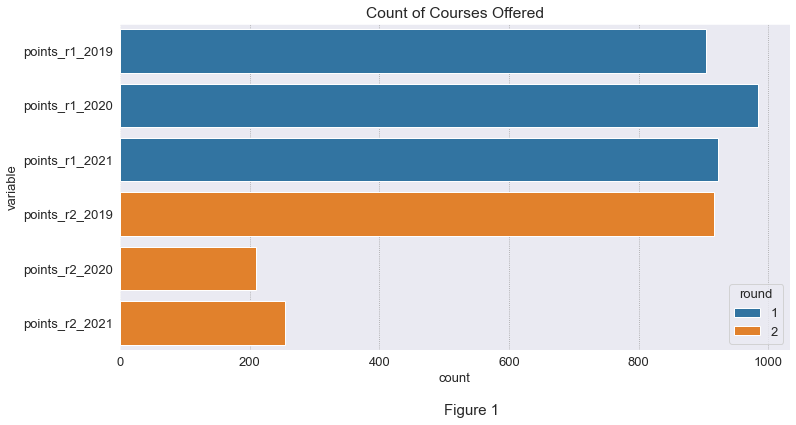

In [33]:

fig, ax = plt.subplots(figsize = (12, 6), sharex = True)
plt.figtext(0.5, -0.025, 'Figure 1', wrap = True, fontsize = 15)
ax.set_title('Count of Courses Offered')

# add col to distinguish between r1 and r2 for hue of countplot
melted_df['round'] = np.where(melted_df['variable'].str.contains('r1|Mid'), '1',
                       np.where(melted_df['variable'].str.contains('r2|EOS'), '2', '0'))

# remove null values
melted_no_null = melted_df[melted_df['value'].notnull()]

# plot count of courses and use 'round' col to set hue, also set dodge to true to shift nested hue elements along axis
plot = sns.countplot(data = melted_no_null, y = 'variable', hue = 'round', dodge  = False);

# calculate percent change between r1 and r1 counts for 2021 and 2021 years
comparison_2020 = (melted_no_null['variable'].value_counts()['points_r1_2020'] / 
                   melted_no_null['variable'].value_counts()['points_r2_2020']) * 100

comparison_2021 = (melted_no_null['variable'].value_counts()['points_r1_2021'] / 
                   melted_no_null['variable'].value_counts()['points_r2_2021']) * 100

spacer = ' ' * 17
print('\n{}2020 R1 offered the most courses (nearly 1000), while 2019 R1 offered the least (circa 900).\n\
{}R2 2019 (i.e: End of Season) had circa 900 offerings, while r2 2020/2021 showed a dramatic\n\
{}decrease from their r1 offerings of circa {} and {} % respectively.\n\
{}\n'.format(spacer, spacer, spacer,round(comparison_2020, 1), round(comparison_2021, 1), spacer))


### Exploring the Spread
***


              The boxplot shows that the R1 and R2 points mean (yellow triangle) increased from 2019
              to 2020 to 2021. The median, 25th percentile, median and 75th percentile all show a
              similar trend for these years. Many outliers can be seen accross the R1 points data.
              The shape of the distributions will be explored Figure 2.



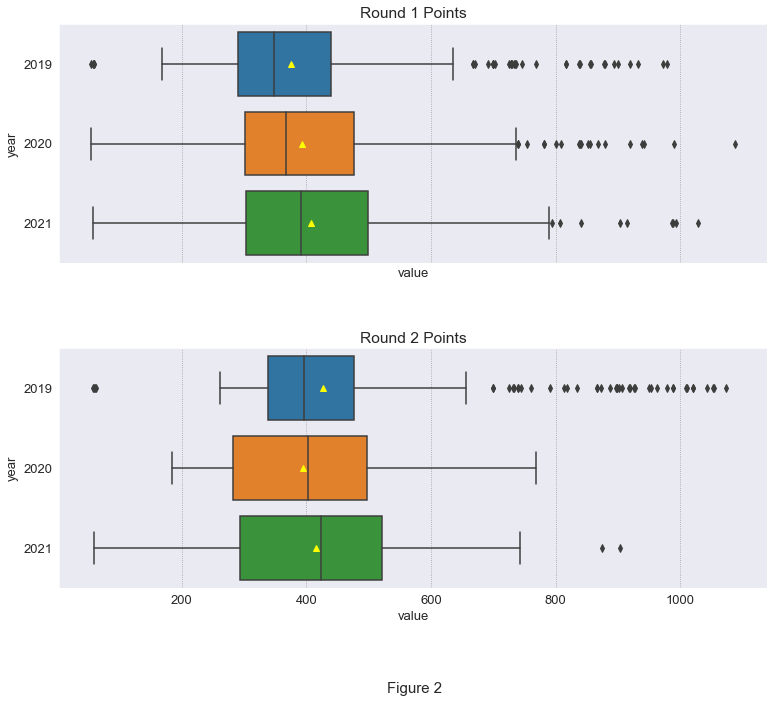

In [34]:
# generate figure with 2 rows
fig, (ax1, ax2) = plt.subplots(2, 1 , figsize = (12, 10), sharex = True)
plt.figtext(0.5, -0.025, 'Figure 2', wrap = True, fontsize = 15)
ax1.set_title('Round 1 Points')
ax2.set_title('Round 2 Points')

# R1 Boxplot, filter melted df variable col by r1 points( i.e where the variabe)
sns.boxplot(ax = ax1, data = melted_df[melted_df['variable'].isin(points_cols[:3])], x = 'value', 
            y = 'year', showmeans = True, meanprops = {'markerfacecolor':'yellow', 
                                                       'markeredgecolor':'yellow'})


## R2 Boxplot, filter melted df variable col by r2 points
sns.boxplot(ax = ax2, data = melted_df[melted_df['variable'].isin(points_cols[3:])], x = 'value', 
            y = 'year', showmeans = True, meanprops={'markerfacecolor':'yellow', 
                                                     'markeredgecolor':'yellow'})

plt.tight_layout(pad = 4)

string_spacer = [' ' * 14 for i in range(6)]
print('\n{}The boxplot shows that the R1 and R2 points mean (yellow triangle) increased from 2019\n\
{}to 2020 to 2021. The median, 25th percentile, median and 75th percentile all show a\n\
{}similar trend for these years. Many outliers can be seen accross the R1 points data.\n\
{}The shape of the distributions will be explored Figure 2.\n'.format(*string_spacer))

### Probability Density
***
Although the CAO plots are discrete in nature, a histogram / KDE plot will now be used to model the probability distirbution.



As per the CAO website certain characters / strings are present in the points data to give more information.<br>
- Hastag symbol (#) : Course has a Test / Interview / Portfolio / Audition <br>
- Asterix symbol (*): Course was not offered to everyone.<br>



In [35]:
def plot_hist_multi(df, title, plot_ref, bin_num, y_limit): 
    '''This function accepts a df and plot parameters to plot custom grid of histogram / kde plots'''

    # plot 1:
    # isolate first col of df and use passed plot ref as axex ref
    sns.histplot(data = df, x = df.iloc[:, 0], ax = ax[plot_ref], label = df.columns[0], 
                 kde = True, color = 'blue', alpha = 0.15, bins = bin_num)
    
    # plot 2:
    sns.histplot(data = df, x = df.iloc[:, 1], ax = ax[plot_ref], label = df.columns[1], 
                 kde = True, color = 'red', alpha = 0.15, bins = bin_num)
    
    # use passed plot ref (n, n) to determine formatting
    ax[plot_ref].set_xlabel('Points')    
    ax[plot_ref].title.set_text(title)
    ax[plot_ref].set_ylim(bottom = 0, top = y_limit)
    ax[plot_ref].legend()
    return


              When looking at plot 1 to 3: the bin distribution and KDE plots shows that the 2019 R1 / R2 points
              have somewhat of a right skewed normal distribution with a second mode starting to appear at approx 500
              points. In R1 2020 the mode appears more prevelant, growing even larger in R1 2021. This mode increasing
              in the higher points region of R1 2021 shows the increase in the count of higher points courses offered to
              students.

              Plots 4 to 6 show the distribution of courses where not all students were offered places. Interestingly the
              points distribution also trends at the higher side in 2021, which esentially means that there is probably a
              correlation between increase in points and not all students being offered places on that year (# in dataset).



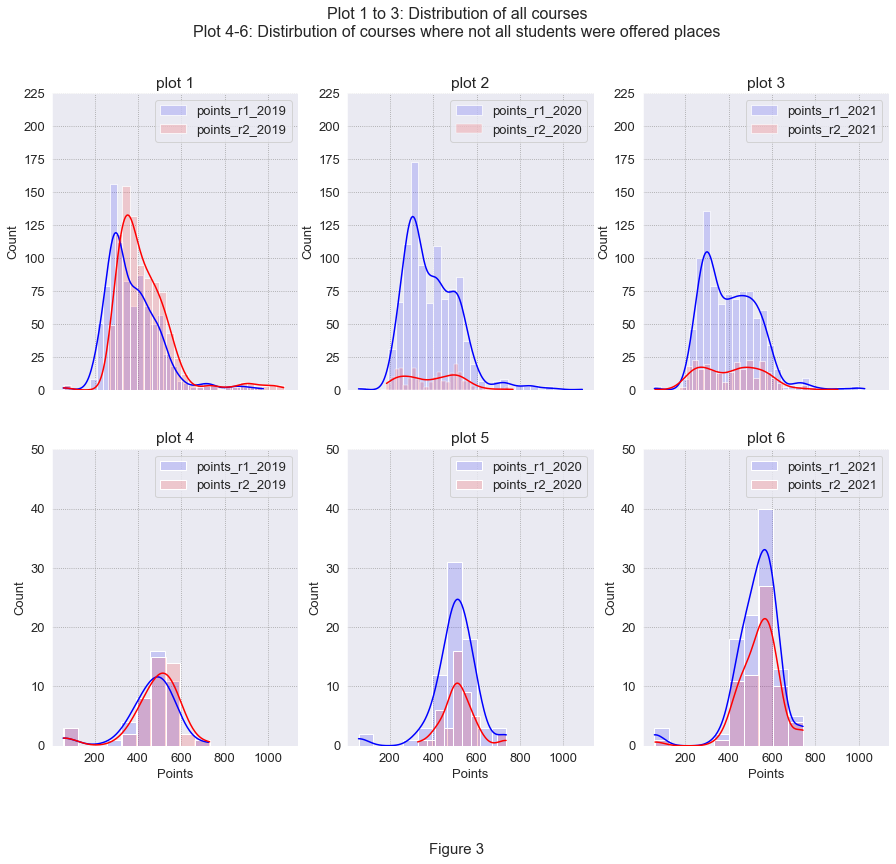

In [36]:
# make 2, 3 grid for plotting
fig, ax = plt.subplots(2, 3, sharex = True, figsize = (15, 12))
plt.figtext(0.5, 0, 'Figure 3', wrap = True, horizontalalignment = 'center', fontsize = 15);  
fig.suptitle('Plot 1 to 3: Distribution of all courses\nPlot 4-6: Distirbution of courses\
 where not all students were offered places', fontsize=16)


#filter df for asterix character OR 
#regex = '\*|\#\*' 
regex = '\*' 
df_filtered_2019 = all_courses[all_courses['special_chars_2019'].str.contains(regex)]    
df_filtered_2020 = all_courses[all_courses['special_chars_2020'].str.contains(regex)]
df_filtered_2021 = all_courses[all_courses['special_chars_2021'].str.contains(regex)]


# plot  where no *asterix present
# i.e remove cases where course was not offered to everyone
plot_hist_multi(df_filtered_2019[['points_r1_2019', 'points_r2_2019']], 'plot 4', plot_ref = (1, 0), 
                bin_num = 10, y_limit = 50)  

plot_hist_multi(df_filtered_2020[['points_r1_2020', 'points_r2_2020']], 'plot 5', plot_ref = (1, 1), 
                bin_num = 10, y_limit = 50)  

plot_hist_multi(df_filtered_2021[['points_r1_2021', 'points_r2_2021']], 'plot 6', plot_ref = (1, 2), 
                bin_num = 10, y_limit = 50) 


# plot 3 years with no filter
plot_hist_multi(all_courses[['points_r1_2019', 'points_r2_2019']], 'plot 1', plot_ref = (0, 0), 
                bin_num = 30, y_limit = 225)  

plot_hist_multi(all_courses[['points_r1_2020', 'points_r2_2020']], 'plot 2', plot_ref = (0, 1), 
                bin_num = 30, y_limit = 225)  

plot_hist_multi(all_courses[['points_r1_2021', 'points_r2_2021']], 'plot 3', plot_ref = (0, 2), 
                bin_num = 30, y_limit = 225) 



string_spacer = [' ' * 14 for i in range(8)]
print('\n{}When looking at plot 1 to 3: the bin distribution and KDE plots shows that the 2019 R1 / R2 points\n\
{}have somewhat of a right skewed normal distribution with a second mode starting to appear at approx 500\n\
{}points. In R1 2020 the mode appears more prevelant, growing even larger in R1 2021. This mode increasing\n\
{}in the higher points region of R1 2021 shows the increase in the count of higher points courses offered to\n\
{}students.\n\n\
{}Plots 4 to 6 show the distribution of courses where not all students were offered places. Interestingly the\n\
{}points distribution also trends at the higher side in 2021, which esentially means that there is probably a\n\
{}correlation between increase in points and not all students being offered places on that year (# in dataset).\n'.format(*string_spacer))

### Compare 2020 to 2021 (by category)
***

In [37]:
# group by category
category_r1_comparison = all_courses[['category', 'points_r1_2020', 'points_r1_2021']].groupby('category').mean()

# make new col showing % difference between 2020 and 2021 for R1 points
category_r1_comparison['percent_change'] = round(100 - category_r1_comparison['points_r1_2020'] / 
                                                 category_r1_comparison['points_r1_2021'] *100, 2)

# display mean points grouped by category, and display % change
category_r1_comparison.head(5)

,points_r1_2020,points_r1_2021,percent_change
category,,,
Agriculture,355.666667,371.375000,4.23
Architecture and construction,342.620000,364.571429,6.02
Arts,463.071429,448.680412,-3.21
Biological and related sciences,423.047619,456.048780,7.24
Business and administration,361.540146,381.471074,5.22



                                                                                     Figure 4 shows that most categories went up in points by circa
                                                                                     5 to 10 %. This data makes sense based on the findings from
                                                                                     Figure 2 and 3. Interdisciplinary programmes/qualifications
                                                                                     had a dramatic 25 % decrease from year 2020 to 2021



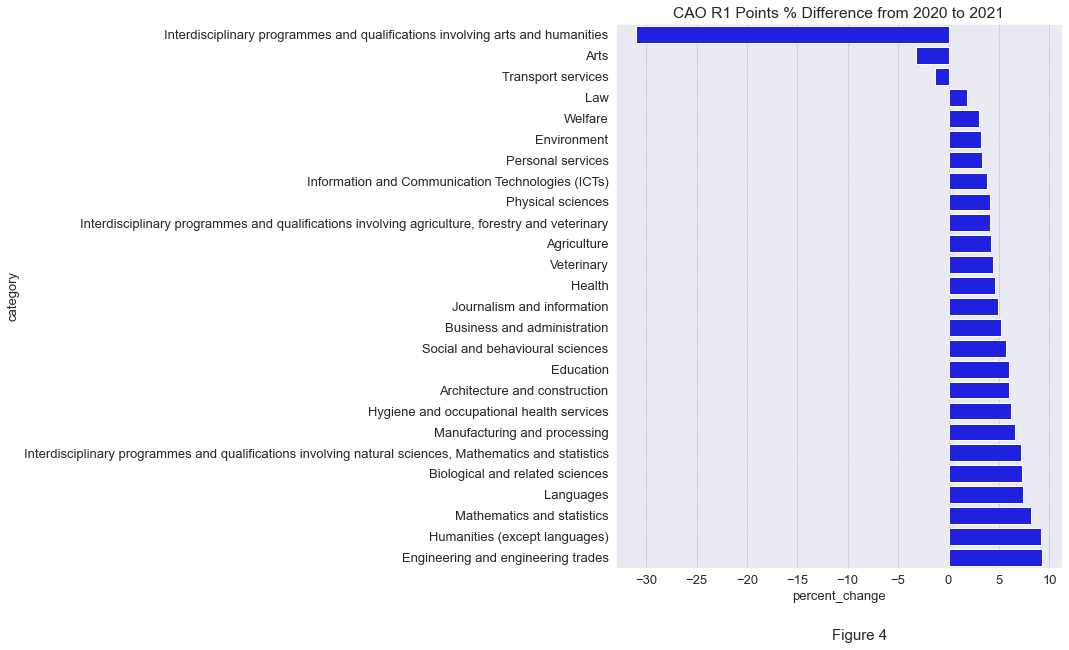

In [38]:
fig, ax = plt.subplots(figsize = (8, 10))

# sort points ascending   
category_r1_comparison.sort_values(by = 'percent_change', inplace = True)

ax = sns.barplot(data = category_r1_comparison, x = 'percent_change', y = category_r1_comparison.index, 
                 color = 'b')

plt.figtext(0.5, 0.025, 'Figure 4', wrap = True, fontsize = 15)
ax.set_title('CAO R1 Points % Difference from 2020 to 2021');

string_spacer = [' ' * 85 for i in range(5)]
print('\n{}Figure 4 shows that most categories went up in points by circa\n\
{}5 to 10 %. This data makes sense based on the findings from\n\
{}Figure 2 and 3. Interdisciplinary programmes/qualifications\n\
{}had a dramatic 25 % decrease from year 2020 to 2021\n'.format(*string_spacer))  


### Mean R1 Points by Institute
***

In [39]:
# group by institute and get mean
institute_r1_comparison = all_courses[['institution', 'points_r1_2019', 'points_r1_2020', 'points_r1_2021']].groupby('institution').mean()

# calc mean for round 1 over 3 years in new col       
institute_r1_comparison['mean_r1_points'] = institute_r1_comparison.loc[: , 'points_r1_2019' : 'points_r1_2021'].mean(axis = 1)

# sort mean points ascending   
institute_r1_comparison.sort_values(by = 'mean_r1_points', ascending = False, inplace = True)
institute_r1_comparison.head(3)

,points_r1_2019,points_r1_2020,points_r1_2021,mean_r1_points
institution,,,,
RCSI University of Medicine & Health Sciences,469.000000,626.000000,647.666667,580.888889
"Dun Laoghaire Institute of Art, Design and Technology",561.294118,538.000000,524.250000,541.181373
Trinity College Dublin,481.789474,478.483333,537.888889,499.387232



                                                    Figure 5 shows the top 10  Average R1 CAO points offered by the given
                                                    instituions from 2019 - 2021. Not surprisingly Dublin is present 6 times
                                                    in the top 10.



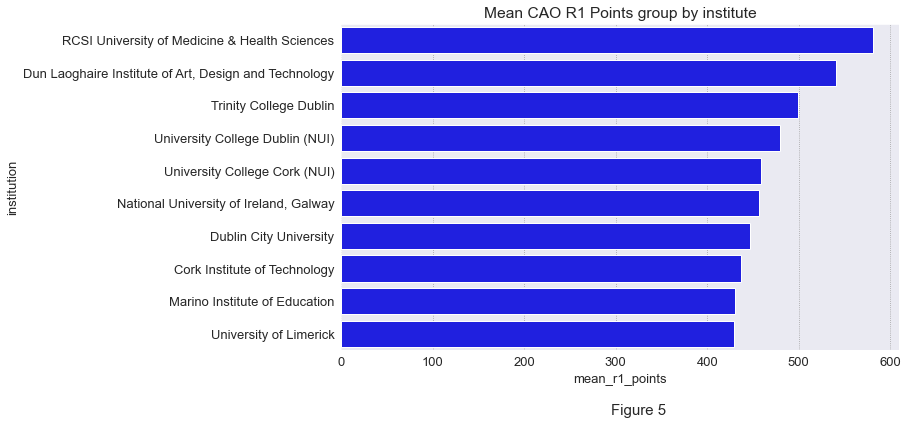

In [40]:
fig, ax = plt.subplots(figsize = (10, 6))

# isolate top 10 institutes by R1 points
institute_r1_comparison = institute_r1_comparison.head(10)

ax = sns.barplot(data = institute_r1_comparison, x = 'mean_r1_points', y = institute_r1_comparison.index, color = 'b')
plt.figtext(0.5, -0.025, 'Figure 5', wrap = True, fontsize = 15)
ax.set_title('Mean CAO R1 Points group by institute');

string_spacer = [' ' *52 for i in range(5)]
print('\n{}Figure 5 shows the top 10  Average R1 CAO points offered by the given\n\
{}instituions from 2019 - 2021. Not surprisingly Dublin is present 6 times\n\
{}in the top 10.\n'.format(*string_spacer))    

# End
***